In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/sensor_data_1_bulan copy.csv')
df['datetime'] = pd.to_datetime(df['tanggal'] + ' ' + df['jam'])
df = df.sort_values('datetime').set_index('datetime')
df = df[['power']]

In [ ]:
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
df['dow_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df['dow_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)

In [ ]:
df['power_roll24'] = df['power'].rolling(24).mean().fillna(method='bfill')

In [ ]:
scaler = MinMaxScaler()
df['power_scaled'] = scaler.fit_transform(df[['power']])

In [ ]:
features = df[['power_scaled', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'power_roll24']].fillna(0).values

In [ ]:
def create_sequences(data, input_steps=24, output_steps=1):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(features, input_steps=48, output_steps=24)

In [ ]:
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(24)
])
model.compile(optimizer='adam', loss='mse')

In [ ]:
# --- TRAIN ---
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1079
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0352
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0308
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0298
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0296
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0288
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0289
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0286
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0282
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0283
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0284
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0280
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0282
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0281
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.028

In [ ]:
last_seq = X[-1]
predictions = []
input_seq = last_seq.copy()

for _ in range(100):
    pred = model.predict(np.expand_dims(input_seq, axis=0), verbose=0)[0]

    pred_power = pred[0]
    time_features = input_seq[-1, 1:]

    new_input = np.concatenate([[pred_power], time_features])
    input_seq = np.vstack([input_seq[1:], new_input])

    predictions.append(pred_power)

In [ ]:

start_time = df.index[-1] + pd.Timedelta(hours=1)
future_times = [start_time + pd.Timedelta(hours=i) for i in range(100)]

In [ ]:
-
pred_scaled = model.predict(np.expand_dims(X[-1], axis=0))[0]
pred_actual = scaler.inverse_transform(pred_scaled.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


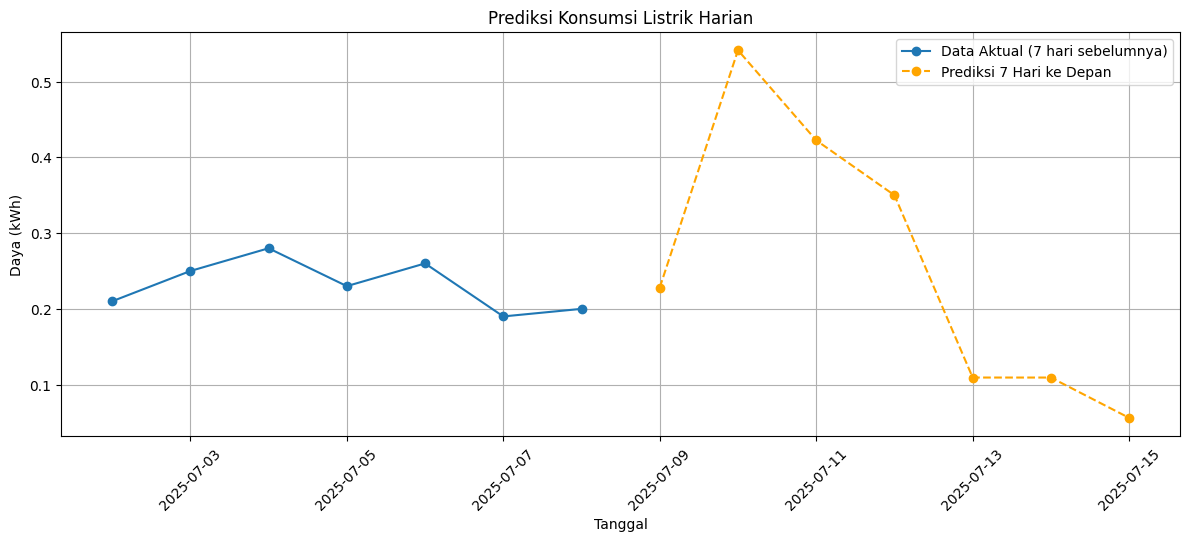

In [ ]:
pred_actual = np.array(predictions).flatten()

future_times = future_times[:len(pred_actual)]

plt.figure(figsize=(15, 5))
plt.plot(df.index[-100:], df['power'].values[-100:], label='Data Aktual (sebelumnya)')
plt.plot(future_times, pred_actual, label='Prediksi 100 jam ke depan', linestyle='--', color='orange')
plt.xlabel('Waktu')
plt.ylabel('Daya (kW)')
plt.title('Prediksi Konsumsi Listrik (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()